#### 변경사항
1. 수정한 부분 Markdown 및 셀 안에 주석(#변경)으로 표시
2. Hyper Parameter Tuning by Grid Search
3. Percentage Errors 추가

In [1]:
# 참고
#https://deep-deep-deep.tistory.com/60

## Set-up (라이브러리, 파라미터, 함수 설정)

In [2]:
# -----------------------------------------------------------------
# 변경: 라이브러리 추가(warnings, matplotlib, seaborn) ; np.set_printoptions 추가
# 라이브러리 불러오기
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 테이블에 소수 자리수형태로 나타내기
np.set_printoptions(suppress=True)

# GPU 1개만 쓰기
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
# -----------------------------------------------------------------

2022-07-11 06:36:01.753779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 06:36:01.776812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 06:36:01.777286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# 빈폴더 생성
if not os.path.exists('./TIME_SERIES/'):
    os.mkdir('./TIME_SERIES/')
if not os.path.exists('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/')
if not os.path.exists('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/')
    
print(os.getcwd())

/home/alfa_members/hyunjo/tensorflow2


In [4]:
# <---------------- Google Colab에서 돌릴 경우 ----------------> 

# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
dict_args = dict()
dict_args['raw_file'] = './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
# dict_args['preprocessed_file'] = './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/CLEAN_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['allVar_raw_file'] = './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/allVar_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['allVar_preprocessed_file'] = './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/allVar_CLEAN_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['min_max_file'] = './TIME_SERIES/min_max.csv'
dict_args["window_size"] = 4
dict_args["features"] = ''
dict_args["label"] = ['Temp(°C)','Temp_1hrAfter(°C)','Temp_2hrAfter(°C)','Temp_3hrAfter(°C)','Temp_4hrAfter(°C)','Temp_5hrAfter(°C)',
                      'Temp_6hrAfter(°C)','Temp_7hrAfter(°C)','Temp_8hrAfter(°C)','Temp_9hrAfter(°C)','Temp_10hrAfter(°C)',
                      'Temp_11hrAfter(°C)','Temp_12hrAfter(°C)']
dict_args["index"] = ['AreaCode','AreaName','Timestamp']
dict_args["area"] = "속초"
dict_args["test_size"] = 120
dict_args['model_file'] = ''
dict_args["param_list"] =  {
                            "LSTM": {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            "GRU": 
                                    {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            }


In [6]:
# 한글명 -> 영문명 변경
english_var = {
    '지점' :  'AreaCode',
    '지점명' :  'AreaName',
    '일시' :  'Timestamp',
    '기온(°C)' :  'Temp(°C)',
    '강수량(mm)' :  'WaterFall(mm)',
    '풍속(m/s)' :  'WindSpeed(m/s)',
    '풍향(16방위)' :  'WindDir(16)',
    '습도(%)' :  'Dampness(%)',
    '증기압(hPa)' :  'AirPressure(hPa)',
    '이슬점온도(°C)' :  'DewPointTemp(°C)',
    '현지기압(hPa)' :  'LocalPressure(hPa)',
    '해면기압(hPa)' :  'SeaLevelPressure(hPa)',
    '일조(hr)' :  'SunShine(hr)',
    '일사(MJ/m2)' :  'Radiation(MJ/m2)',
    '적설(cm)' :  'Snow(cm)',
    '3시간신적설(cm)' :  '3hrsSnow(cm)',
    '전운량(10분위)' :  'FullCloud(10)',
    '중하층운량(10분위)' :  'LowMiddleCloud(10)',
    '운형(운형약어)' :  'CloudShape',
    '최저운고(100m )' :  'MinMaxCloudHeight(100m)',
    '기온 QC플래그' :  'TempQCFlag',
    '강수량 QC플래그' :  'WaterFallQCFlag',
    '풍속 QC플래그' :  'WindSpeedQCFlag',
    '풍향 QC플래그' :  'WindDirQCFlag',
    '습도 QC플래그' :  'DampnessQCFlag',
    '현지기압 QC플래그' :  'LocalPressureQCFlag',
    '해면기압 QC플래그' :  'SeaLevelPressureQCFlag',
    '일조 QC플래그' :  'SunShineQCFlag',
    '일사 QC플래그' :  'RadiationQCFlag',
}

print(english_var)

{'지점': 'AreaCode', '지점명': 'AreaName', '일시': 'Timestamp', '기온(°C)': 'Temp(°C)', '강수량(mm)': 'WaterFall(mm)', '풍속(m/s)': 'WindSpeed(m/s)', '풍향(16방위)': 'WindDir(16)', '습도(%)': 'Dampness(%)', '증기압(hPa)': 'AirPressure(hPa)', '이슬점온도(°C)': 'DewPointTemp(°C)', '현지기압(hPa)': 'LocalPressure(hPa)', '해면기압(hPa)': 'SeaLevelPressure(hPa)', '일조(hr)': 'SunShine(hr)', '일사(MJ/m2)': 'Radiation(MJ/m2)', '적설(cm)': 'Snow(cm)', '3시간신적설(cm)': '3hrsSnow(cm)', '전운량(10분위)': 'FullCloud(10)', '중하층운량(10분위)': 'LowMiddleCloud(10)', '운형(운형약어)': 'CloudShape', '최저운고(100m )': 'MinMaxCloudHeight(100m)', '기온 QC플래그': 'TempQCFlag', '강수량 QC플래그': 'WaterFallQCFlag', '풍속 QC플래그': 'WindSpeedQCFlag', '풍향 QC플래그': 'WindDirQCFlag', '습도 QC플래그': 'DampnessQCFlag', '현지기압 QC플래그': 'LocalPressureQCFlag', '해면기압 QC플래그': 'SeaLevelPressureQCFlag', '일조 QC플래그': 'SunShineQCFlag', '일사 QC플래그': 'RadiationQCFlag'}


In [7]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = 8

In [8]:
# 로그메시지
def line_logging(*messages):
    import datetime
    log_time = datetime.datetime.today().strftime('[%Y/%m/%d %H:%M:%S]')
    log = list()
    for message in messages:
        log.append(str(message))
    print(log_time + ':[' + ' '.join(log) + ']', flush=True)


# 변수 데이터 분포도
def draw_graph(df): 
    fig, axes = plt.subplots(4, 4, sharex=False)

    sns.distplot(df['Temp(°C)'], bins=70, kde=False, ax=axes[0,0])
    sns.distplot(df['WaterFall(mm)'], bins=70, kde=False, ax=axes[0,1])
    sns.distplot(df['WindSpeed(m/s)'], bins=70, kde=False, ax=axes[0,2])
    sns.distplot(df['WindDir(16)'], bins=70, kde=False, ax=axes[0,3])
    sns.distplot(df['Dampness(%)'], bins=70, kde=False, ax=axes[1,0])
    sns.distplot(df['AirPressure(hPa)'], bins=70, kde=False, ax=axes[1,1])
    sns.distplot(df['DewPointTemp(°C)'], bins=70, kde=False, ax=axes[1,2])
    sns.distplot(df['LocalPressure(hPa)'], bins=70, kde=False, ax=axes[1,3])
    sns.distplot(df['SeaLevelPressure(hPa)'], bins=70, kde=False, ax=axes[2,0])
    sns.distplot(df['SunShine(hr)'], bins=70, kde=False, ax=axes[2,1])
    sns.distplot(df['Radiation(MJ/m2)'], bins=70, kde=False, ax=axes[2,2])
    sns.distplot(df['Snow(cm)'], bins=70, kde=False, ax=axes[2,3]) 
    sns.distplot(df['3hrsSnow(cm)'], bins=70, kde=False, ax=axes[3,0])
    sns.distplot(df['FullCloud(10)'], bins=70, kde=False, ax=axes[3,1])
    sns.distplot(df['LowMiddleCloud(10)'], bins=70, kde=False, ax=axes[3,2])
    sns.distplot(df['CloudShape'], bins=70, kde=False, ax=axes[3,3])
    
    plt.plot()


def make_preprocessed_file(p_args):

    try: 
        df = pd.read_csv(p_args['allVar_raw_file'], encoding='utf-8') 
    except:
        df = pd.read_csv(p_args['allVar_raw_file'], encoding='euc-kr')

    # display(df)
    # print(df.columns)
    columns = ['AreaCode','AreaName','Timestamp']
    columns.extend(p_args["features"])
    print(columns)

    df = df[columns]
    df = df[df['AreaName'] == p_args["area"]] 
    df.index = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%S')

    df = df[p_args["features"]]
    
    # 변수 Float Type으로 저장 및 Null값 제거 
    df = df.astype('float32')
    df = df.fillna(0)
    print(df.info())
    print(df.isna().sum())
    display(df)
    df.to_csv(p_args['allVar_preprocessed_file'], encoding='utf-8')
    return p_args


def make_dataset_regression(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        # print('feature list: ', np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
        # print('label list: ', np.array(label.iloc[i:i+window_size])) 
    return np.array(feature_list), np.array(label_list)


def split_dataset_regression(p_args, scaling_flag=True):
   
    df = pd.read_csv(p_args["allVar_preprocessed_file"])
    # df = df.fillna(0)
    df = df.set_index('Timestamp')
    # df = df.astype(float)

    # 수치 정규화 
    if scaling_flag: 
        print('정규화된 데이터입니다.')
        df_scaled = df.copy()
        
        min_max_df = pd.DataFrame() 
        for col in df_scaled.columns:
            min_ = np.min(df_scaled[col])
            max_ = np.max(df_scaled[col])

            min_max_dict = dict()
            scaled_list = list()
            for x in df_scaled[col]:
                scaled_x = (x - min_) / (max_ - min_)
                scaled_list.append(scaled_x)
            df_scaled[col] = scaled_list   
            
            min_max_dict['VAR'] = col
            min_max_dict['min'] = min_
            min_max_dict['max'] = max_            
                
            min_max_list = []
            min_max_list.append(min_max_dict)
            tmpdf = pd.DataFrame(min_max_list)
            # display(tmpdf)
            min_max_df = pd.concat([min_max_df, tmpdf], axis=0) 
                
        # 중간에 MIN_MAX 파일로 저장 (나중에 원래 수치로 다시 계산할때 필요)
        min_max_df.to_csv(p_args["min_max_file"], index=None, encoding='utf-8')

    else:
        print('정규화가 제외된 데이터입니다.')
        df_scaled = df.copy()
        # display(df_scaled.head(5))
    
    # Train과 Test 분리
    train = df_scaled[:-p_args["test_size"]]
    test = df_scaled[-p_args["test_size"]:]
    print("train: ", train.shape, type(train))
    print("test: ", test.shape, type(test))
    # display(train.head(5))
    # display(test.head(5))
    
    train_feature, train_label = make_dataset_regression(train[p_args["features"]], train[p_args["label"]], window_size = p_args["window_size"])
    print("train_feature: ", train_feature.shape, type(train_feature))
    print("train_label: ", train_label.shape, type(train_label))
    
    # Train에서 Train Set, Valid Set 분리 (검증셋)
    from sklearn.model_selection import train_test_split
    X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.2)
    
    # ----------------------------------------------------
    # 변경: y_train -> y_train_list (y_train_list에 Temp뿐만 아니라, Temp_1hrAfter, Temp_2hrAfter 등 변수를 함께 묶어서 저장)
    X_train = X_train.astype(float)
    y_train_list = y_train.astype(float)
    X_valid = X_valid.astype(float)
    y_valid_list = y_valid.astype(float)

    print("X_train: ",  X_train.shape, type(X_train))
    print("y_train_list: ",  y_train_list.shape, type(y_train))
    print("X_valid: ",  X_valid.shape, type(X_valid))
    print("y_valid_list: ",  y_valid_list.shape, type(y_valid))
    
    # Test set에서 feature, label 분리
    X_test, y_test = make_dataset_regression(test[p_args["features"]], test[p_args["label"]], window_size = p_args["window_size"])
    y_test_list = y_test
    print("X_test: ", X_test.shape)
    print("y_test_list: ", y_test_list.shape)
    
    print(X_train[0])
    print(y_train[0])

    return train, test, train_feature, train_label, X_train, y_train_list, X_valid, y_valid_list, X_test, y_test_list


# 변경: argument 변경 ; input_shape은 (4, 19)로 고정
def build_LSTM_model(input_optimizer, input_dropout, input_lr, batch_size, loss_function):
    model = Sequential()
    model.add(LSTM(32, 
              input_shape=(4, 19),
              activation='relu',
              return_sequences=False))
    model.add(Dropout(input_dropout))
    model.add(Dense(4, 'relu'))
    model.add(Dense(1))
    # print(model.summary())

    optimizer = input_optimizer(lr=input_lr)
    model.compile(loss = loss_function, 
                  optimizer = optimizer,
                  metrics=['mae'],
                  )
    return model


'''
def build_GRU_model(p_args, train_set):
    model = Sequential()
    model.add(GRU(32, 
              input_shape=(train_set.shape[1], train_set.shape[2]),
              activation='relu',
              return_sequences=False))
    model.add(Dense(4, 'relu'))
    model.add(Dense(1))
    print(model.summary())

    # cp = ModelCheckpoint(p_args['model_file'], save_best_only=True)
    model.compile(loss='mean_squared_error', 
                  optimizer= Adam(learning_rate=p_args["param_list"]["LSTM"]["learning_rate"]), 
                  metrics=['mae'],
                  )
    return model
'''


def reverse_minmax(label, min_, max_):
    result_list = list()
    for element in label:
        new_element = element * (max_ - min_) + min_
        result_list.append(new_element)
    result_array = np.array(result_list)
    return result_array


# 변경: 한글 변수명 -> 영문 변경 함수 추가
def change_col_to_english(df, english_var):
    english_names = list()
        
    for col in df.columns.tolist():
        try:
            english_names.append(english_var.get(col))
        except:
            pass
    df.columns = english_names
    return df
# -----------------------------------------------------------------

## EDA (변수별 분포 그래프 그리기, 필요한 변수 탐색)

Index(['AreaCode', 'AreaName', 'Timestamp', 'Temp(°C)', 'TempQCFlag',
       'WaterFall(mm)', 'WaterFallQCFlag', 'WindSpeed(m/s)', 'WindSpeedQCFlag',
       'WindDir(16)', 'WindDirQCFlag', 'Dampness(%)', 'DampnessQCFlag',
       'AirPressure(hPa)', 'DewPointTemp(°C)', 'LocalPressure(hPa)',
       'LocalPressureQCFlag', 'SeaLevelPressure(hPa)',
       'SeaLevelPressureQCFlag', 'SunShine(hr)', 'SunShineQCFlag',
       'Radiation(MJ/m2)', 'RadiationQCFlag', 'Snow(cm)', '3hrsSnow(cm)',
       'FullCloud(10)', 'LowMiddleCloud(10)', 'CloudShape',
       'MinMaxCloudHeight(100m)'],
      dtype='object')
16
변수별 NULL 값 확인----
AreaCode                     0
AreaName                     0
Timestamp                    0
Temp(°C)                     0
TempQCFlag                 744
WaterFall(mm)              702
WaterFallQCFlag            597
WindSpeed(m/s)               0
WindSpeedQCFlag            744
WindDir(16)                  0
WindDirQCFlag              744
Dampness(%)                  0
Dam

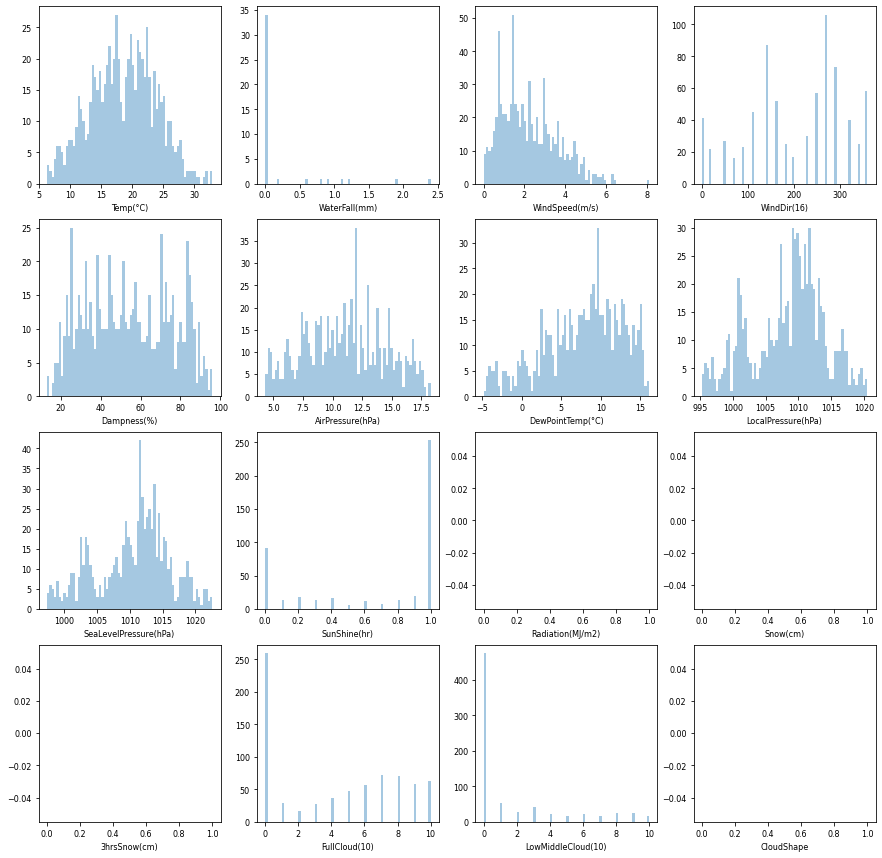

In [9]:
# 파일 읽기
df = pd.read_csv(dict_args['raw_file'], encoding='euc-kr')
# 한글 변수명 영문으로 바꾸기
df = change_col_to_english(df, english_var)
# display(df)
print(df.columns)
df = df[df['AreaName']==dict_args["area"]]


# 변수별 데이터 분포 확인
graph_cols = ['Temp(°C)','WaterFall(mm)','WindSpeed(m/s)','WindDir(16)','Dampness(%)','AirPressure(hPa)','DewPointTemp(°C)',
              'LocalPressure(hPa)','SeaLevelPressure(hPa)','SunShine(hr)','Radiation(MJ/m2)','Snow(cm)','3hrsSnow(cm)',
              'FullCloud(10)','LowMiddleCloud(10)','CloudShape']
print(len(graph_cols))
graph_df = df[graph_cols]
draw_graph(graph_df)

# 변수별 NULL 값 확인 
print("변수별 NULL 값 확인----")
print(df.isna().sum())
print("-"*80)

drop_columns = [
"TempQCFlag",
"WaterFall(mm)",
"WaterFallQCFlag",
"WindSpeedQCFlag",
"WindDir(16)",
"WindDirQCFlag",
"DampnessQCFlag",
"LocalPressureQCFlag",
"SeaLevelPressureQCFlag",
"SunShine(hr)",
"SunShineQCFlag",
"Radiation(MJ/m2)",
"RadiationQCFlag",
"Snow(cm)",
"3hrsSnow(cm)",
"FullCloud(10)",
"LowMiddleCloud(10)",
"CloudShape",
"MinMaxCloudHeight(100m)"
]

# 불필요한 변수 제거 (Flag 변수는 BIT변수라서 제거, NULL값이 많은 변수 제거, 구름과 관련된 변수는 우선 제거)
df = df.drop(drop_columns, axis=1)

# 변경: 1~12 시간 뒤 기온 변수 생성
df['Temp_1hrAfter(°C)'] = df['Temp(°C)'].shift(-1)
df['Temp_2hrAfter(°C)'] = df['Temp(°C)'].shift(-2)
df['Temp_3hrAfter(°C)'] = df['Temp(°C)'].shift(-3)
df['Temp_4hrAfter(°C)'] = df['Temp(°C)'].shift(-4)
df['Temp_5hrAfter(°C)'] = df['Temp(°C)'].shift(-5)
df['Temp_6hrAfter(°C)'] = df['Temp(°C)'].shift(-6)
df['Temp_7hrAfter(°C)'] = df['Temp(°C)'].shift(-7)
df['Temp_8hrAfter(°C)'] = df['Temp(°C)'].shift(-8)
df['Temp_9hrAfter(°C)'] = df['Temp(°C)'].shift(-9)
df['Temp_10hrAfter(°C)'] = df['Temp(°C)'].shift(-10)
df['Temp_11hrAfter(°C)'] = df['Temp(°C)'].shift(-11)
df['Temp_12hrAfter(°C)'] = df['Temp(°C)'].shift(-12)


# 제일 밑 12개 행 제거 (Temp_1hrAfter 등 변수 생성시 Null값 존재)
df = df.head(df.shape[0] - 12)

# 필요한 변수만 선택해서 allVar_Raw File 명으로 저장
df.to_csv(dict_args['allVar_raw_file'], index=None)

# Feature 리스트 저장
column_list = df.columns.tolist()
del column_list[0:3]
dict_args["features"] = column_list
# -----------------------------------------------------------------

## Raw Data 전처리 및 Preprocessed File 생성

In [10]:
make_preprocessed_file(dict_args)

['AreaCode', 'AreaName', 'Timestamp', 'Temp(°C)', 'WindSpeed(m/s)', 'Dampness(%)', 'AirPressure(hPa)', 'DewPointTemp(°C)', 'LocalPressure(hPa)', 'SeaLevelPressure(hPa)', 'Temp_1hrAfter(°C)', 'Temp_2hrAfter(°C)', 'Temp_3hrAfter(°C)', 'Temp_4hrAfter(°C)', 'Temp_5hrAfter(°C)', 'Temp_6hrAfter(°C)', 'Temp_7hrAfter(°C)', 'Temp_8hrAfter(°C)', 'Temp_9hrAfter(°C)', 'Temp_10hrAfter(°C)', 'Temp_11hrAfter(°C)', 'Temp_12hrAfter(°C)']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-05-01 01:00:00 to 2022-05-31 12:00:00
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temp(°C)               732 non-null    float32
 1   WindSpeed(m/s)         732 non-null    float32
 2   Dampness(%)            732 non-null    float32
 3   AirPressure(hPa)       732 non-null    float32
 4   DewPointTemp(°C)       732 non-null    float32
 5   LocalPressure(hPa)     732 non-null    float32
 6   SeaLevelPres

,Temp(°C),WindSpeed(m/s),Dampness(%),AirPressure(hPa),DewPointTemp(°C),LocalPressure(hPa),SeaLevelPressure(hPa),Temp_1hrAfter(°C),Temp_2hrAfter(°C),Temp_3hrAfter(°C),Temp_4hrAfter(°C),Temp_5hrAfter(°C),Temp_6hrAfter(°C),Temp_7hrAfter(°C),Temp_8hrAfter(°C),Temp_9hrAfter(°C),Temp_10hrAfter(°C),Temp_11hrAfter(°C),Temp_12hrAfter(°C)
Timestamp,,,,,,,,,,,,,,,,,,,
2022-05-01 01:00:00,11.400000,1.7,46.0,6.200000,0.1,1011.700012,1013.799988,11.900000,10.700000,10.5,10.2,10.200000,13.000000,14.100000,14.700000,16.200001,17.700001,18.400000,19.500000
2022-05-01 02:00:00,11.900000,3.4,38.0,5.300000,-1.9,1011.099976,1013.200012,10.700000,10.500000,10.2,10.2,13.000000,14.100000,14.700000,16.200001,17.700001,18.400000,19.500000,20.299999
2022-05-01 03:00:00,10.700000,2.7,46.0,5.900000,-0.4,1010.900024,1013.000000,10.500000,10.200000,10.2,13.0,14.100000,14.700000,16.200001,17.700001,18.400000,19.500000,20.299999,20.700001
2022-05-01 04:00:00,10.500000,1.9,44.0,5.600000,-1.2,1010.700012,1012.799988,10.200000,10.200000,13.0,14.1,14.700000,16.200001,17.700001,18.400000,19.500000,20.299999,20.700001,16.000000
2022-05-01 05:00:00,10.200000,1.2,40.0,5.000000,-2.8,1010.000000,1012.099976,10.200000,13.000000,14.1,14.7,16.200001,17.700001,18.400000,19.500000,20.299999,20.700001,16.000000,13.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 08:00:00,22.400000,3.6,32.0,8.600000,4.8,1004.099976,1006.099976,24.299999,21.700001,22.0,20.6,20.500000,21.600000,21.400000,21.100000,21.900000,24.200001,25.900000,24.299999
2022-05-31 09:00:00,24.299999,2.9,28.0,8.500000,4.6,1004.200012,1006.200012,21.700001,22.000000,20.6,20.5,21.600000,21.400000,21.100000,21.900000,24.200001,25.900000,24.299999,22.799999
2022-05-31 10:00:00,21.700001,2.0,63.0,16.299999,14.3,1004.700012,1006.700012,22.000000,20.600000,20.5,21.6,21.400000,21.100000,21.900000,24.200001,25.900000,24.299999,22.799999,22.700001


{'raw_file': './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/WEATHER_ASOS_2205.csv',
 'allVar_raw_file': './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/allVar_WEATHER_ASOS_2205.csv',
 'allVar_preprocessed_file': './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/allVar_CLEAN_WEATHER_ASOS_2205.csv',
 'min_max_file': './TIME_SERIES/min_max.csv',
 'window_size': 4,
 'features': ['Temp(°C)',
  'WindSpeed(m/s)',
  'Dampness(%)',
  'AirPressure(hPa)',
  'DewPointTemp(°C)',
  'LocalPressure(hPa)',
  'SeaLevelPressure(hPa)',
  'Temp_1hrAfter(°C)',
  'Temp_2hrAfter(°C)',
  'Temp_3hrAfter(°C)',
  'Temp_4hrAfter(°C)',
  'Temp_5hrAfter(°C)',
  'Temp_6hrAfter(°C)',
  'Temp_7hrAfter(°C)',
  'Temp_8hrAfter(°C)',
  'Temp_9hrAfter(°C)',
  'Temp_10hrAfter(°C)',
  'Temp_11hrAfter(°C)',
  'Temp_12hrAfter(°C)'],
 'label': ['Temp(°C)',
  'Temp_1hrAfter(°C)',
  'Temp_2hrAfter(°C)',
  'Temp_3hrAfter(°C)',
  'Temp_4hrAfter(°C)',
  'Temp_5hrAfter(°C)',
  'Temp_6hrAfter(°C)',
  'Temp_7hrAfter(°C)',
  'Temp_8hrAfter(°C)',
 

## Train Set, Valid Set, Test Set 생성

In [11]:
train, test, train_feature, train_label, X_train, y_train_list, X_valid, y_valid_list, X_test, y_test_list = split_dataset_regression(dict_args, scaling_flag=True)

정규화된 데이터입니다.
train:  (612, 19) <class 'pandas.core.frame.DataFrame'>
test:  (120, 19) <class 'pandas.core.frame.DataFrame'>
train_feature:  (608, 4, 19) <class 'numpy.ndarray'>
train_label:  (608, 13) <class 'numpy.ndarray'>
X_train:  (486, 4, 19) <class 'numpy.ndarray'>
y_train_list:  (486, 13) <class 'numpy.ndarray'>
X_valid:  (122, 4, 19) <class 'numpy.ndarray'>
y_valid_list:  (122, 13) <class 'numpy.ndarray'>
X_test:  (116, 4, 19)
y_test_list:  (116, 13)
[[0.43445693 0.60493827 0.56626506 0.56428571 0.70334928 0.77380952
  0.77470356 0.41198502 0.38576779 0.35580524 0.31835206 0.29588015
  0.29213483 0.24344569 0.19850187 0.1835206  0.20599251 0.23220974
  0.25468165]
 [0.41198502 0.49382716 0.6746988  0.65714286 0.77511962 0.76587302
  0.76679842 0.38576779 0.35580524 0.31835206 0.29588015 0.29213483
  0.24344569 0.19850187 0.1835206  0.20599251 0.23220974 0.25468165
  0.26966292]
 [0.38576779 0.62962963 0.68674699 0.62857143 0.75598086 0.75396825
  0.75494071 0.35580524 0.3183520

## 모델 학습하기 (1시간 뒤 온도를 Label로 고정해서 학습; 예시: Model 4) 

In [12]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import make_scorer

In [13]:
# 변경: Grid Search 부분 추가
# 1 Point 뒤 예측


y_train_name = dict_args['label'][1]  # Temp_1hrAfter(°C)

# y_train_list, y_valid_list에서 Temp_1hrAfter(°C) 데이터만 가져와서 y_train, y_valid 생성 
y_train = list()
for i in range(y_train_list.shape[0]):
    y_train.append(y_train_list[i, 1])   # 리스트에서 두번째 열만 가져오기 ; y_train_list[i, 1] -> Temp_1hrAfter(°C)
y_train = np.array(y_train)
# print(y_train)
# print(y_train.shape)

y_valid = list()
for i in range(y_valid_list.shape[0]):
    y_valid.append(y_valid_list[i, 1])   # 리스트에서 두번째 열만 가져오기 ; y_valid_list[i, 1] -> Temp_1hrAfter(°C) 
y_valid = np.array(y_valid)
# print(y_valid)


# keras.wrapper를 활용
model4 = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_LSTM_model, epochs=60, verbose=0)

# <------------------------------HyperParameter Tuning by GridSearch------------------------------>

# input_optimizer = optimizer
input_optimizer = [Adam]
# input_dropout : dropout 비율
input_dropout = [0] 
# input_lr : learning_rate
input_lr = [0.0005]    
# batch_size
batch_size = [50]
# loss function
loss_function = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error',
                'cosine_similarity', 'huber_loss', 'log_cosh']


# hyperparameter 를 dictionary로 바꾸기
param_grid = dict(input_optimizer = input_optimizer,
                  input_dropout = input_dropout,
                  input_lr = input_lr,
                  batch_size = batch_size,
                  loss_function = loss_function)
print(param_grid)


grid_search = GridSearchCV(estimator=model4,
                             param_grid=param_grid,
                             cv=2,
                             n_jobs=1,
                             scoring="neg_mean_absolute_error",
                             verbose=0)

line_logging('GRID SEARCH 시작.')
grid_result = grid_search.fit(X_train, 
                              y_train,
                              validation_data=(X_valid, y_valid),
                              )
line_logging('GRID SEARCH 완료.')
# gridesearch 결과
print("최고의 파라미터 :", grid_result.best_params_)
print("최고 평균 정확도 : {}".format(grid_result.best_score_))


{'input_optimizer': [<class 'keras.optimizer_v2.adam.Adam'>], 'input_dropout': [0], 'input_lr': [0.0005], 'batch_size': [50], 'loss_function': ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'huber_loss', 'log_cosh']}
[2022/07/11 06:36:04]:[GRID SEARCH 시작.]


2022-07-11 06:36:04.040357: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 06:36:04.040997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 06:36:04.041538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 06:36:04.042020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

[2022/07/11 06:36:48]:[GRID SEARCH 완료.]
최고의 파라미터 : {'batch_size': 50, 'input_dropout': 0, 'input_lr': 0.0005, 'input_optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'loss_function': 'mean_absolute_error'}
최고 평균 정확도 : -0.023617638376770694


In [15]:
grid_result.best_params_

{'batch_size': 50,
 'input_dropout': 0,
 'input_lr': 0.0005,
 'input_optimizer': keras.optimizer_v2.adam.Adam,
 'loss_function': 'mean_absolute_error'}

In [ ]:
# Best Model Parameter
# {'batch_size': 50,
#  'input_dropout': 0,
#  'input_lr': 0.0005,
#  'input_optimizer': keras.optimizer_v2.adam.Adam,
#  'loss_function': 'mean_absolute_error'}

------------------------------ MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)  예측 결과입니다 ------------------------------


4/4 [==============================] - 0s 2ms/step - loss: 0.0161 - mae: 0.0161


,Test Predictions,Actuals
0,0.639356,0.662921
1,0.587557,0.610487
2,0.551379,0.561798
3,0.525967,0.558052
4,0.503980,0.516854
...,...,...
111,0.625641,0.677903
112,0.600450,0.580524
113,0.569866,0.591760
114,0.545366,0.539326


,Test Predictions,Actuals,Test Predictions_original_values,Actuals_original_values
0,0.639356,0.662921,23.270798,23.9
1,0.587557,0.610487,21.887764,22.5
2,0.551379,0.561798,20.921826,21.2
3,0.525967,0.558052,20.243332,21.1
4,0.503980,0.516854,19.656273,20.0
...,...,...,...,...
111,0.625641,0.677903,22.904613,24.3
112,0.600450,0.580524,22.232013,21.7
113,0.569866,0.591760,21.415435,22.0
114,0.545366,0.539326,20.761259,20.6


Text(0.5, 0.98, 'Trend Prediction')

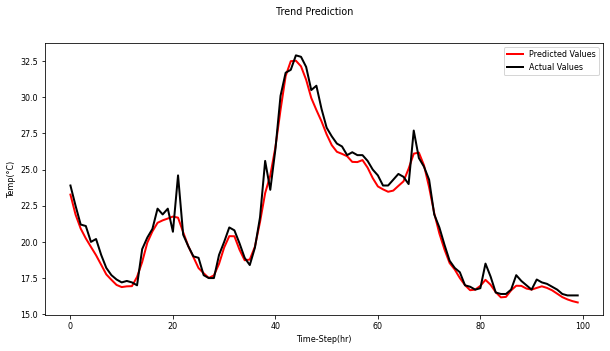

In [30]:
model_name = "LSTM"
y_train_name = dict_args['label'][1]  # Temp_1hrAfter(°C)
dict_args['model_file'] = './TIME_SERIES/' + 'MODEL4' + '_' + model_name + '_VAR_' + str(len(dict_args['features'])) + '_' + y_train_name 


# GRID SEARCH에서 도출된 BEST 모델 학습
result_model = build_LSTM_model(
                            grid_result.best_params_['input_optimizer'],
                            grid_result.best_params_['input_dropout'],
                            grid_result.best_params_['input_lr'],
                            grid_result.best_params_['batch_size'],
                            grid_result.best_params_['loss_function'],
                            )
# BEST 모델 훈련
line_logging('BEST MODEL 훈련 시작.')
result_model.fit(X_train, 
                 y_train,
                 epochs = 60,
                 verbose = 1,
                 validation_data=(X_valid, y_valid),
                 callbacks=[ModelCheckpoint(dict_args['model_file'], save_best_only=True)])
line_logging('BEST MODEL 훈련 완료.')

In [31]:
# 변경: 전에는 y_test를 바로 사용했지만, 지금은 y_test_list에서 학습대상이 되는 변수값을 y_test로 저장해야됨
from tensorflow.keras.models import load_model

# y_test_list에서 Temp_1hrAfter(°C) 데이터만 가져와서 y_test 생성

y_test = list()
for i in range(y_test_list.shape[0]):
    y_test.append(y_test_list[i, 1])     # 리스트에서 두번째 열만 가져오기 ; y_test_list[i, 1] -> Temp_1hrAfter(°C)
y_test = np.array(y_test)

print('-'*30, dict_args['model_file'].split('/')[-1], ' 예측 결과입니다', '-'*30)
model4 = load_model(dict_args['model_file'])
model4.evaluate(X_test, y_test)

------------------------------ MODEL4_LSTM_VAR_19_Temp_1hrAfter(°C)  예측 결과입니다 ------------------------------


4/4 [==============================] - 0s 2ms/step - loss: 0.0161 - mae: 0.0161


[0.016060845926404, 0.016060845926404]

,Test Predictions,Actuals,percentErrors,Test Predictions_original_values,Actuals_original_values,percentErrors_original_values
0,0.641011,0.662921,-0.033052,23.314981,23.9,5.317514
1,0.589364,0.610487,-0.034600,21.936022,22.5,5.276183
2,0.553800,0.561798,-0.014236,20.986463,21.2,5.819904
3,0.530416,0.558052,-0.049523,20.362101,21.1,4.877725
4,0.507984,0.516854,-0.017161,19.763174,20.0,5.741793
...,...,...,...,...,...,...
111,0.630888,0.677903,-0.069352,23.044720,24.3,4.348289
112,0.604932,0.580524,0.042043,22.351674,21.7,7.322560
113,0.573296,0.591760,-0.031202,21.507016,22.0,5.366920
114,0.550399,0.539326,0.020531,20.895641,20.6,6.748167


Text(0.5, 0.98, 'Trend Prediction')

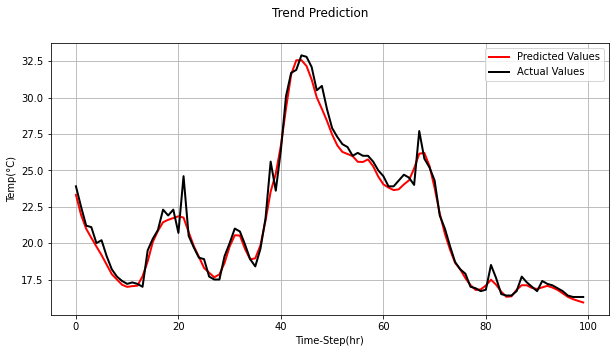

In [41]:
# 변경: PercentageErrors 추가 

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2

train_predictions = model4.predict(X_test).flatten()
percentErrors = (train_predictions - y_test) / y_test
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 
                                   'Actuals':y_test, 
                                   'percentErrors':percentErrors})



# display(train_results)

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_1hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][1]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

    for label_col in train_results.columns:
        label = np.array(train_results[label_col])
        result_array = reverse_minmax(label, min_, max_)
        train_results[label_col + '_original_values'] = result_array
display(train_results)

plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")
# 변경: time range 바꿈
plt.plot(train_results['Test Predictions_original_values'][:100], 'r', label='Predicted Values')
plt.plot(train_results['Actuals_original_values'][:100], 'k', label='Actual Values')
plt.legend()
plt.suptitle("Trend Prediction")

predicted_future_point:  23.31498095989227
true_future_point:  22.5
history_values:  [23.6 24.7 24.9 24.8]
PercentError 3.6221375995212037



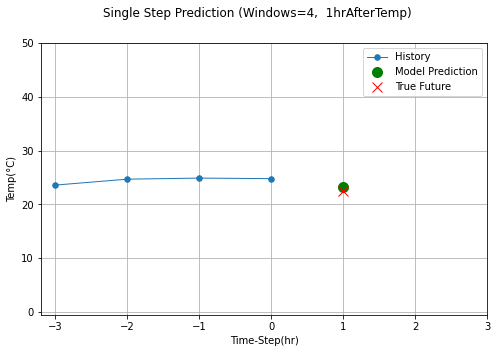

In [36]:
# 변경: PercentageErrors 추가 

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


future_time_step = 1
predicted_future_point = model4.predict(X_test).flatten()[0]
# y_train도 1시간 뒤에 값이므로 y_test도 1시간 뒤 값으로 맞춰주기
true_future_point = y_test[0 + future_time_step]

history_values = X_test[0][:, 7]    # X_test의 8 번째 열 (Temp_1hrAfter(°C))에 대한 4 times window 만들기   
history_time_steps = list(range(-len(history_values)+1, 1))

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_1hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][1]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

# min-max scaling된 값을 원래값으로 되돌리기
predicted_future_point = predicted_future_point * (max_ - min_) + min_
true_future_point = true_future_point * (max_ - min_) + min_
history_values = list(map(lambda x: (x * (max_ - min_) + min_), history_values))
history_values = np.array(history_values)

print("predicted_future_point: ", predicted_future_point)
print("true_future_point: ", true_future_point)
print("history_values: ", history_values)
print('PercentError', ((predicted_future_point - true_future_point) / true_future_point * 100))
print()

labels = ["History", "True Future", "Model Prediction"]
marker = [".-", "rx", "go"]

plt.xlim([-3.2, 3])
plt.ylim([-0.5, 50])
plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")

# 과거 기온 값 (windows=4)
plt.plot(history_time_steps, history_values, marker[0], markersize=11, label=labels[0])
# 학습된 모델로 예측된 1시간후 기온
plt.plot(future_time_step, predicted_future_point, marker[2], markersize=10, label=labels[2])
# 실제 기온
plt.plot(future_time_step, true_future_point, marker[1], markersize=10, label=labels[1]) 

plt.legend()
plt.suptitle("Single Step Prediction (Windows=4,  1hrAfterTemp)")
plt.show()


## 여기까지

## 밑에서부턴 v0.4

## 모델 학습하기 (2시간 뒤 온도를 Label로 고정해서 학습; 예시: Model 5) 

In [ ]:
# 변경: Model 5 추가 
# 변경: 전에는 y_train/y_valid를 바로 사용했지만, 지금은 y_train_list/y_valid_list에서 학습대상이 되는 변수값을 y_train/y_valid로 저장해야됨
# 변경: 저장할 Model File 이름 변경
# 2 Point 뒤 예측

model_name = "LSTM"

y_train_name = dict_args['label'][2]  # Temp_2hrAfter(°C)

# y_train_list, y_valid_list에서 Temp_2hrAfter(°C) 데이터만 가져와서 y_train, y_valid 생성 
y_train = list()
for i in range(y_train_list.shape[0]):
    y_train.append(y_train_list[i, 2])   # 리스트에서 두번째 열만 가져오기 ; y_train_list[i, 2] -> Temp_2hrAfter(°C)
y_train = np.array(y_train)
# print(y_train)
# print(y_train.shape)

y_valid = list()
for i in range(y_valid_list.shape[0]):
    y_valid.append(y_valid_list[i, 2])   # 리스트에서 두번째 열만 가져오기 ; y_valid_list[i, 2] -> Temp_2hrAfter(°C) 
y_valid = np.array(y_valid)
# print(y_valid)

dict_args['model_file'] = './TIME_SERIES/' + 'MODEL5' + '_' + model_name + '_VAR_' + str(len(dict_args['features'])) + '_' + y_train_name 

model5 = build_LSTM_model(dict_args, X_train)


epochs = dict_args["param_list"][model_name]["epochs"]
batch_size = dict_args["param_list"][model_name]["batch_size"]

model5.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
           epochs=epochs, 
           batch_size=batch_size,
           callbacks=[ModelCheckpoint(dict_args['model_file'], save_best_only=True)],
)

In [ ]:
# 변경: 전에는 y_test를 바로 사용했지만, 지금은 y_test_list에서 학습대상이 되는 변수값을 y_test로 저장해야됨
from tensorflow.keras.models import load_model

# y_test_list에서 Temp_2hrAfter(°C) 데이터만 가져와서 y_test 생성

y_test = list()
for i in range(y_test_list.shape[0]):
    y_test.append(y_test_list[i, 2])     # 리스트에서 두번째 열만 가져오기 ; y_test_list[i, 2] -> Temp_2hrAfter(°C)
y_test = np.array(y_test)

print('-'*30, dict_args['model_file'].split('/')[-1], ' 예측 결과입니다', '-'*30)
model5 = load_model(dict_args['model_file'])
model5.evaluate(X_test, y_test)

In [ ]:
#---------------------------------------------------------------#
# 추가: model5 추가

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2

train_predictions = model5.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test})
# display(train_results)

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_2hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][1]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

    for label_col in train_results.columns:
        label = np.array(train_results[label_col])
        result_array = reverse_minmax(label, min_, max_)
        train_results[label_col + '_original_values'] = result_array
display(train_results)

plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")
plt.plot(train_results['Test Predictions_original_values'][:100], 'r', label='Predicted Values')
plt.plot(train_results['Actuals_original_values'][:100], 'k', label='Actual Values')
plt.legend()
plt.suptitle("Trend Prediction")
#---------------------------------------------------------------#

In [ ]:
# 변경 Single Point Graph 코드 추가

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


future_time_step = 2
predicted_future_point = model5.predict(X_test).flatten()[0]
# y_train도 2시간 뒤에 값이므로 y_test도 2시간 뒤 값으로 맞춰주기
true_future_point = y_test[0 + future_time_step]

history_values = X_test[0][:, 8]    # X_test의 9 번째 열 (Temp_2hrAfter(°C))에 대한 4 times window 만들기   
history_time_steps = list(range(-len(history_values)+1, 1))

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
# display(min_max_df)

for col in dict_args["label"]:
    # Temp_2hrAfter(°C)만 reverse min-max
    if col != dict_args["label"][2]:
        continue
    # print(col)
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']

# min-max scaling된 값을 원래값으로 되돌리기
predicted_future_point = predicted_future_point * (max_ - min_) + min_
true_future_point = true_future_point * (max_ - min_) + min_
history_values = list(map(lambda x: (x * (max_ - min_) + min_), history_values))
history_values = np.array(history_values)

print("predicted_future_point: ", predicted_future_point)
print("true_future_point: ", true_future_point)
print("history_values: ", history_values)
print()

labels = ["History", "True Future", "Model Prediction"]
marker = [".-", "rx", "go"]

plt.xlim([-3.2, 3])
plt.ylim([-0.5, 50])
plt.xlabel("Time-Step(hr)")
plt.ylabel("Temp(°C)")

# 과거 기온 값 (windows=4)
plt.plot(history_time_steps, history_values, marker[0], markersize=11, label=labels[0])
# 학습된 모델로 예측된 2시간후 기온
plt.plot(future_time_step, predicted_future_point, marker[2], markersize=10, label=labels[2])
# 실제 기온
plt.plot(future_time_step, true_future_point, marker[1], markersize=10, label=labels[1]) 

plt.legend()
plt.suptitle("Single Step Prediction (Windows=4,  2hrAfterTemp)")
plt.show()
